In [5]:
import pandas as pd
import datetime as dt
import pickle
import random
from itertools import combinations

In [88]:
def flatten(lst):
    return [item for sublist in lst for item in sublist]

def make_fset(x, drop=True):
    if len(set(x.split(' '))) < 2:
        if drop == False:
            print(f"[{ct}] WARNING: Features for '{x}' (self-self PPI) detected ...")
            x1 = x.split(' ')[0]
            fset = frozenset({x1})
            return(fset)
        else:
            return()   
    else:
        x1 = x.split(' ')[0]
        x2 = x.split(' ')[1]
        fset = frozenset({x1,x2})
        return(fset)

In [4]:
gold_std_file = '/stor/work/Marcotte/project/rmcox/leca/ppi_ml/data/gold_stds/all.gold.cmplx.noRibos.merged.txt'
pos_outfile = '/stor/work/Marcotte/project/rmcox/leca/ppi_ml/data/unit_testing/all_pos_ppis.txt'

In [5]:
gs_dict = make_gs_dict(gold_std_file)

In [20]:
fset_lst = []
for ppi in gs_dict.values():
    fset_lst.append(ppi)
flat_fsets = set(flatten(fset_lst))
all_pos_ppis = [] 
for ppi in flat_fsets:
    all_pos_ppis.append(list(ppi))

In [22]:
len(all_pos_ppis)

16064

In [8]:
with open(pos_outfile, 'w') as f:
    for ppi in pos_ppis:
        pair = list(ppi)
        line = f'{pair[0]}\t{pair[1]}\n'
        f.write(line)

In [9]:
neg_ppis = get_neg_ppis(gs_dict)

--> # total possible gold standard PPIs = 16064
--> # unique gold standard prots = 2958
--> # total possible negative PPIs = 4357339


In [25]:
neg_ppis & flat_fsets

set()

In [24]:
fmat_file = '../ppi_ml/data/featmats/test_group_merge/featmat_labeled_all_groups_traintest.pkl'
gold_std_file = '/stor/work/Marcotte/project/rmcox/leca/ppi_ml/data/gold_stds/all.gold.cmplx.noRibos.merged.txt'
ml_results_file = '../ppi_ml/results/test_walktrap/archive/ppi_scores_all.csv'

In [25]:
with open(fmat_file, 'rb') as handle:
    fmat = pickle.load(handle)

# assert no ppis are repeated in labeled feature matrix
ppi_counts = fmat.groupby(['ID']).size().sort_values(ascending=False)
assert any(x > 1 for x in ppi_counts) == False, "Non-unique PPI labels detected."

In [63]:
def count_grps(x):
    if type(x) == list:
        return(len(x))
    else:
        return(1)
    
def count_multi(df, col_name):
    n = 0
    for i in range(len(df)):
        if type(df[col_name][i]) == list:
            n += 1
    return(n)

fmat['grp_count'] = [count_grps(i) for i in fmat['group']]
fmat['super_grp_count'] = [count_grps(i) for i in fmat['super_group']]
grp_df = fmat[['ID','grp_count','super_grp_count']]
grp_df.sort_values('grp_count', ascending=False)

,ID,grp_count,super_grp_count
11592,KOG1649 KOG1279,18,1
5136,KOG1649 KOG0386,16,1
5128,KOG1279 KOG0386,15,1
18407,KOG3459 KOG3428,12,1
11611,KOG1279 KOG2570,11,1
...,...,...,...
9095,KOG4163 KOG0892,1,1
9094,KOG4020 KOG0892,1,1
9093,KOG3503 KOG0892,1,1
9092,KOG3230 KOG0892,1,1


In [64]:
n = count_multi(fmat, 'group')
n

1641

In [65]:
n = count_multi(fmat, 'super_group')
n

0

ID             26516
group            848
super_group      356
dtype: int64


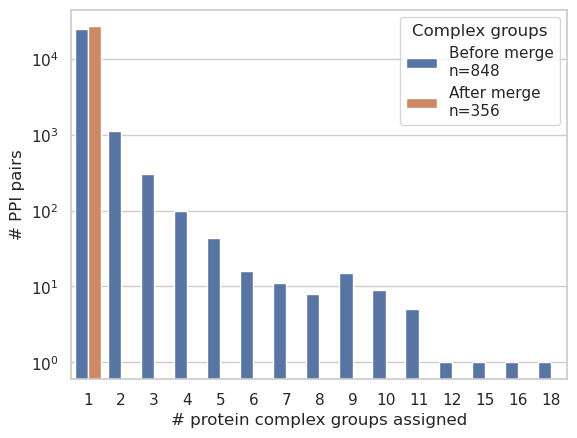

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pdf = pd.melt(grp_df, id_vars=['ID'], value_vars=['grp_count', 'super_grp_count'])
counts = (fmat.explode('group')).nunique()
print(counts[0:3])

sns.set_theme(style="whitegrid")

# set up the figure and axes
fig, ax = plt.subplots()
sns.countplot(data=pdf, x='value', hue='variable')

# set the axis labels and title
ax.set(yscale="log")
ax.set_xlabel('# protein complex groups assigned')
ax.set_ylabel('# PPI pairs')

# adjust legend text
plt.legend(title='Complex groups', loc='upper right', labels=[f'Before merge\nn={counts[1]}', f'After merge\nn={counts[2]}'])

# save plot
plt.savefig(f'../ppi_ml/results/ml_eval/group_merge.png', dpi=300, transparent=True)

# show the plot
plt.show()

In [76]:
# assert all combinations of a cmplx are generated
cmplx_list = []

with open(gold_std_file, 'r') as f:
    ppis = f.read().splitlines()
    num_test = 5
    for p in ppis:
        ogs = p.split(' ')
        if 2 < len(ogs) < 5:
            cmplx_list.append(ogs)
            
for cmplx in cmplx_list:
    num_prots = len(cmplx)
    expected_ppi_number = (num_prots*(num_prots-1))/2
    ppis = [frozenset({i, j}) for i,j in list(combinations(cmplx, 2))]
    assert expected_ppi_number == len(ppis), "Problem with gold standard complexes; make sure each complex contains unique protein IDs (no repeated subunits)."

In [7]:
# assert that there is no overlap between train and test ppis
res = pd.read_csv(ml_results_file)
tt_df = res[(res.set == 'test') | (res.set == 'train')]
tt_df

,Unnamed: 0,ID,label,ppi_score,set
0,0,KOG3409 KOG3013,1,1.0,test
1,1,KOG0358 KOG0362,1,1.0,train
2,2,KOG2072 KOG0643,1,1.0,train
3,3,KOG3677 KOG1560,1,1.0,train
4,4,KOG2314 KOG0643,1,1.0,train
...,...,...,...,...,...
4490157,4490157,KOG4845 KOG1666,-1,0.0,train
4490158,4490158,KOG3229 KOG4795,-1,0.0,train
4490159,4490159,KOG3432 KOG4168,-1,0.0,train
4490160,4490160,KOG2741 KOG4322,-1,0.0,train


In [87]:
tt_ppi_counts = tt_df.groupby(['ID']).size().sort_values(ascending=False)
assert any(x > 1 for x in tt_ppi_counts) == False, "Non-unique PPI labels detected."

In [102]:
train_df = tt_df[(tt_df.set == 'train')]
train_ppis = [make_fset(i, drop=True) for i in train_df['ID']]

test_df = tt_df[(tt_df.set == 'test')]
test_ppis = [make_fset(i, drop=True) for i in test_df['ID']]

assert len(set(test_ppis) & set(train_ppis)) == 0, "Overlap between train and test PPIs detected."

In [8]:
labeled = fmat[(fmat.super_group > 0)]

356

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

options = {
    'node_color': 'black',
    'node_size': 10,
    'width': 1,
}

In [10]:
grp_sizes = pd.DataFrame()
grp, n = np.unique(labeled.super_group, return_counts=True)
grp_counts = dict(zip(grp, n))
len(grp_counts)

356

In [11]:
no_of_colors=len(grp_counts)
color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
       for j in range(no_of_colors)]
color_dict = dict(zip(grp, color))
len(color_dict)

356

In [ ]:
label_dict = dict()
for i in range(len(labeled)):
    edge = (df.ID1[i], df.ID2[i])
    label = df.super_group[i]
    if label not in label_dict.values():
        label_dict.update({edge: str(label)})

In [22]:
def label2color(x):
    if x == 1:
        return('#0072B2')
    elif x == -1:
        return('#F39B7F')
def split2color(x):
    if x == 'test':
        return('#F0E442')
    elif x == 'train':
        return('#00A087')
def grp2color(x, my_dict):
    return my_dict.get(x, -1)

In [13]:
edges = pd.DataFrame()
edges[['ID1','ID2']] = labeled['ID'].str.split(' ', expand=True)
attr = labeled[['super_group', 'label']]
graph_df = edges.join(attr)
graph_df = graph_df.reset_index(drop=True)
graph_df = graph_df.rename(columns={'ID1':'source', 'ID2': 'target'})
graph_df['label_color'] = [label2color(i).lower() for i in graph_df['label']]
graph_df['grp_color'] = [grp2color(i, color_dict).lower() for i in graph_df['super_group']]
graph_df

,source,target,super_group,label,label_color,grp_color
0,ENOG502QR6E,ENOG502QPKB,511,1,#0072b2,#0fa75a
1,KOG0217,ENOG502QPKB,1,-1,#f39b7f,#591b9f
2,ENOG502QPKB,KOG0263,1,-1,#f39b7f,#591b9f
3,KOG2440,ENOG502QPKB,47,-1,#f39b7f,#0e91de
4,KOG3005,ENOG502QPKB,1,-1,#f39b7f,#591b9f
...,...,...,...,...,...,...
26511,KOG1894,KOG1597,1,1,#0072b2,#591b9f
26512,KOG1894,KOG1969,1,-1,#f39b7f,#591b9f
26513,KOG1894,KOG2691,1,1,#0072b2,#591b9f
26514,KOG1894,KOG3400,1,1,#0072b2,#591b9f


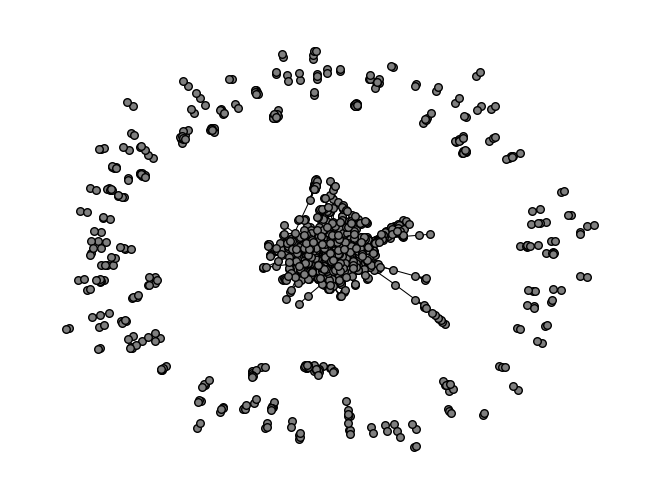

In [14]:
options = {
    'node_color': 'tab:grey',
    'node_size': 30,
    "edgecolors": "black",
    'width': 0.75,
    
}

pos_ppis = graph_df[(graph_df.label==1)]
G = nx.from_pandas_edgelist(pos_ppis, 'source', 'target', edge_attr=True)
pos = nx.spring_layout(G)
#nx.draw(G, pos=nx.spring_layout(G), edge_color=test.grp_color, node_size=10, width=0.5)
nx.draw(G, pos=pos, **options)
plt.show()

In [16]:
len(list(nx.bridges(G)))

240

In [17]:
# assert that there is no overlap between train and test ppis
res = pd.read_csv(ml_results_file)
tt_df = res[(res.set == 'test') | (res.set == 'train')]
tt_df

,Unnamed: 0,ID,label,ppi_score,set
0,0,KOG3409 KOG3013,1,1.0,test
1,1,KOG0358 KOG0362,1,1.0,train
2,2,KOG2072 KOG0643,1,1.0,train
3,3,KOG3677 KOG1560,1,1.0,train
4,4,KOG2314 KOG0643,1,1.0,train
...,...,...,...,...,...
4490157,4490157,KOG4845 KOG1666,-1,0.0,train
4490158,4490158,KOG3229 KOG4795,-1,0.0,train
4490159,4490159,KOG3432 KOG4168,-1,0.0,train
4490160,4490160,KOG2741 KOG4322,-1,0.0,train


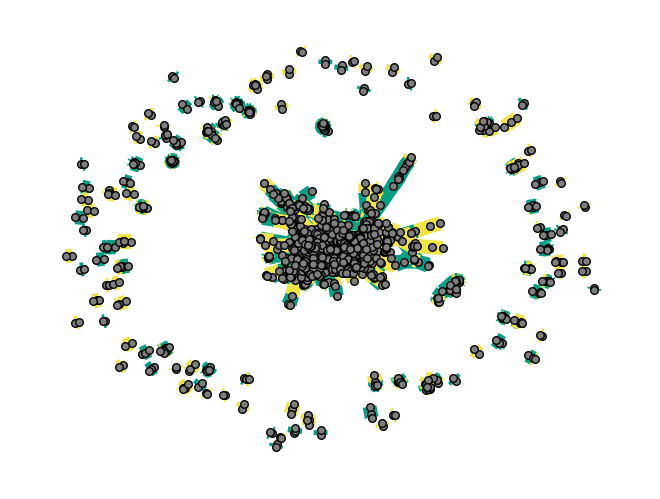

In [23]:
edges = pd.DataFrame()
edges[['ID1','ID2']] = tt_df['ID'].str.split(' ', expand=True)
attr = tt_df[['label', 'set']]
graph_df = edges.join(attr)
graph_df = graph_df.reset_index(drop=True)
graph_df = graph_df.rename(columns={'ID1':'source', 'ID2': 'target'})
graph_df['color'] = [split2color(i).lower() for i in graph_df['set']]

options = {
    'node_color': 'tab:grey',
    'node_size': 30,
    "edgecolors": "black",
    'width': 10,
    
}

pos_ppis = graph_df[(graph_df.label==1)]
G = nx.from_pandas_edgelist(pos_ppis, 'source', 'target', edge_attr=True)
pos = nx.spring_layout(G)
#nx.draw(G, pos=nx.spring_layout(G), edge_color=test.grp_color, node_size=10, width=0.5)
nx.draw(G, pos=pos, edge_color=pos_ppis.color, **options)
plt.show()